# Enhanced Retrieval Techniques with Chroma and LiteLLM

This notebook demonstrates how to build a **Contextual Semantic Search** system using **Chroma Vector Database** and **LiteLLM** with the **Gemini model**. The system processes a folder of PDF documents, builds a knowledge base, and retrieves contextually relevant information to answer user queries. Below is an overview of the tools and methods used, with a focus on **Enhanced Retrieval Techniques**.

---

## Tools Used

1. **Chroma Vector Database**:
   - A vector database designed for storing and querying embeddings.
   - Enables efficient similarity search for retrieving semantically relevant documents.

2. **Sentence Transformers**:
   - A library for generating high-quality embeddings (vector representations) of text.
   - Uses pre-trained models like `all-MiniLM-L6-v2` to convert text into embeddings.

3. **LangChain**:
   - A framework for working with text data, including text splitting and chunking.
   - The `RecursiveCharacterTextSplitter` is used to split text into semantically meaningful chunks.

4. **LiteLLM**:
   - A lightweight library for interacting with large language models (LLMs).
   - Used here to call the **Gemini model** for generating responses based on retrieved context.

5. **PyPDF2**:
   - A library for extracting text from PDF files.
   - Used to process all PDFs in a specified folder.

6. **rank_bm25**:
   - A library for sparse retrieval using the **BM25 algorithm**.
   - Provides state-of-the-art keyword-based retrieval.

---

## Methods and Steps

### Step 1: Extract Text from PDFs
- All PDF files in a specified folder are processed using **PyPDF2**.
- The text from each PDF is extracted and combined into a single string.

### Step 2: Split Text into Chunks
- The combined text is split into smaller chunks using **LangChain's RecursiveCharacterTextSplitter**.
- This ensures that the chunks are semantically meaningful and retain context.

### Step 3: Generate Embeddings
- Each text chunk is converted into an embedding (vector representation) using **Sentence Transformers**.
- The embeddings capture the semantic meaning of the text.

### Step 4: Build the Knowledge Base
- The embeddings and corresponding text chunks are stored in **Chroma Vector Database**.
- This allows for efficient similarity searches based on semantic meaning.

### Step 5: Perform Advanced Retrieval Techniques
- **Entity-Aware Retrieval**: Enhances retrieval by focusing on specific entities mentioned in the query.
- **Hybrid Sparse-Dense Retrieval**: Combines dense (embedding-based) and sparse (BM25-based) retrieval for better results.
- **Multi-Step Document Retrieval**: Iteratively refines the query based on retrieved context.
- **Hypothetical Document Embedding (HyDE)**: Generates a hypothetical document that answers the query and uses its embedding for retrieval.

### Step 6: Generate Responses
- The retrieved chunks are passed as context to the **Gemini model** via **LiteLLM**.
- The model generates a response based on the query and the provided context.

---

## Workflow Overview

1. **Input**: A folder containing PDF documents.
2. **Processing**:
   - Extract text from PDFs.
   - Split text into chunks.
   - Generate embeddings and store them in Chroma.
3. **Query Handling**:
   - Convert the query into an embedding.
   - Use advanced retrieval techniques (Entity-Aware, Hybrid, Multi-Step, HyDE) to retrieve relevant chunks.
   - Generate a response using the Gemini model.
4. **Output**: A contextually accurate answer to the user's query.

---

## Enhanced Retrieval Techniques Explained

### 1. Entity-Aware Retrieval
- Enhances retrieval by focusing on specific entities mentioned in the query.
- Example: For the query `"What is the insurance for car?"`, the system prioritizes documents mentioning "car" and "insurance".

### 2. Hybrid Sparse-Dense Retrieval
- Combines dense retrieval (using embeddings) with sparse retrieval (using **BM25**).
- Ensures both semantic understanding and keyword matching are utilized.
- **BM25** is a state-of-the-art ranking function that handles term frequency and document length normalization better than TF-IDF.

### 3. Multi-Step Document Retrieval
- Iteratively refines the query based on retrieved context.
- Example: After the first retrieval, the query is refined to include context from the top results.

### 4. Hypothetical Document Embedding (HyDE)
- Generates a hypothetical document that answers the query and uses its embedding for retrieval.
- Example: For the query `"What is the insurance for car?"`, a hypothetical document like `"Car insurance is a type of policy that covers..."` is generated and used for retrieval.

---

## Why This Approach?

- **Contextual Semantic Search**: Goes beyond keyword matching to understand the meaning and context of the query.
- **Efficient Retrieval**: Chroma enables fast and scalable similarity searches.
- **Advanced Techniques**: Combines multiple retrieval methods for improved accuracy.
- **High-Quality Responses**: The Gemini model generates accurate and contextually relevant answers.

---

Let’s get started! You can see the full workflow in the diagram below.

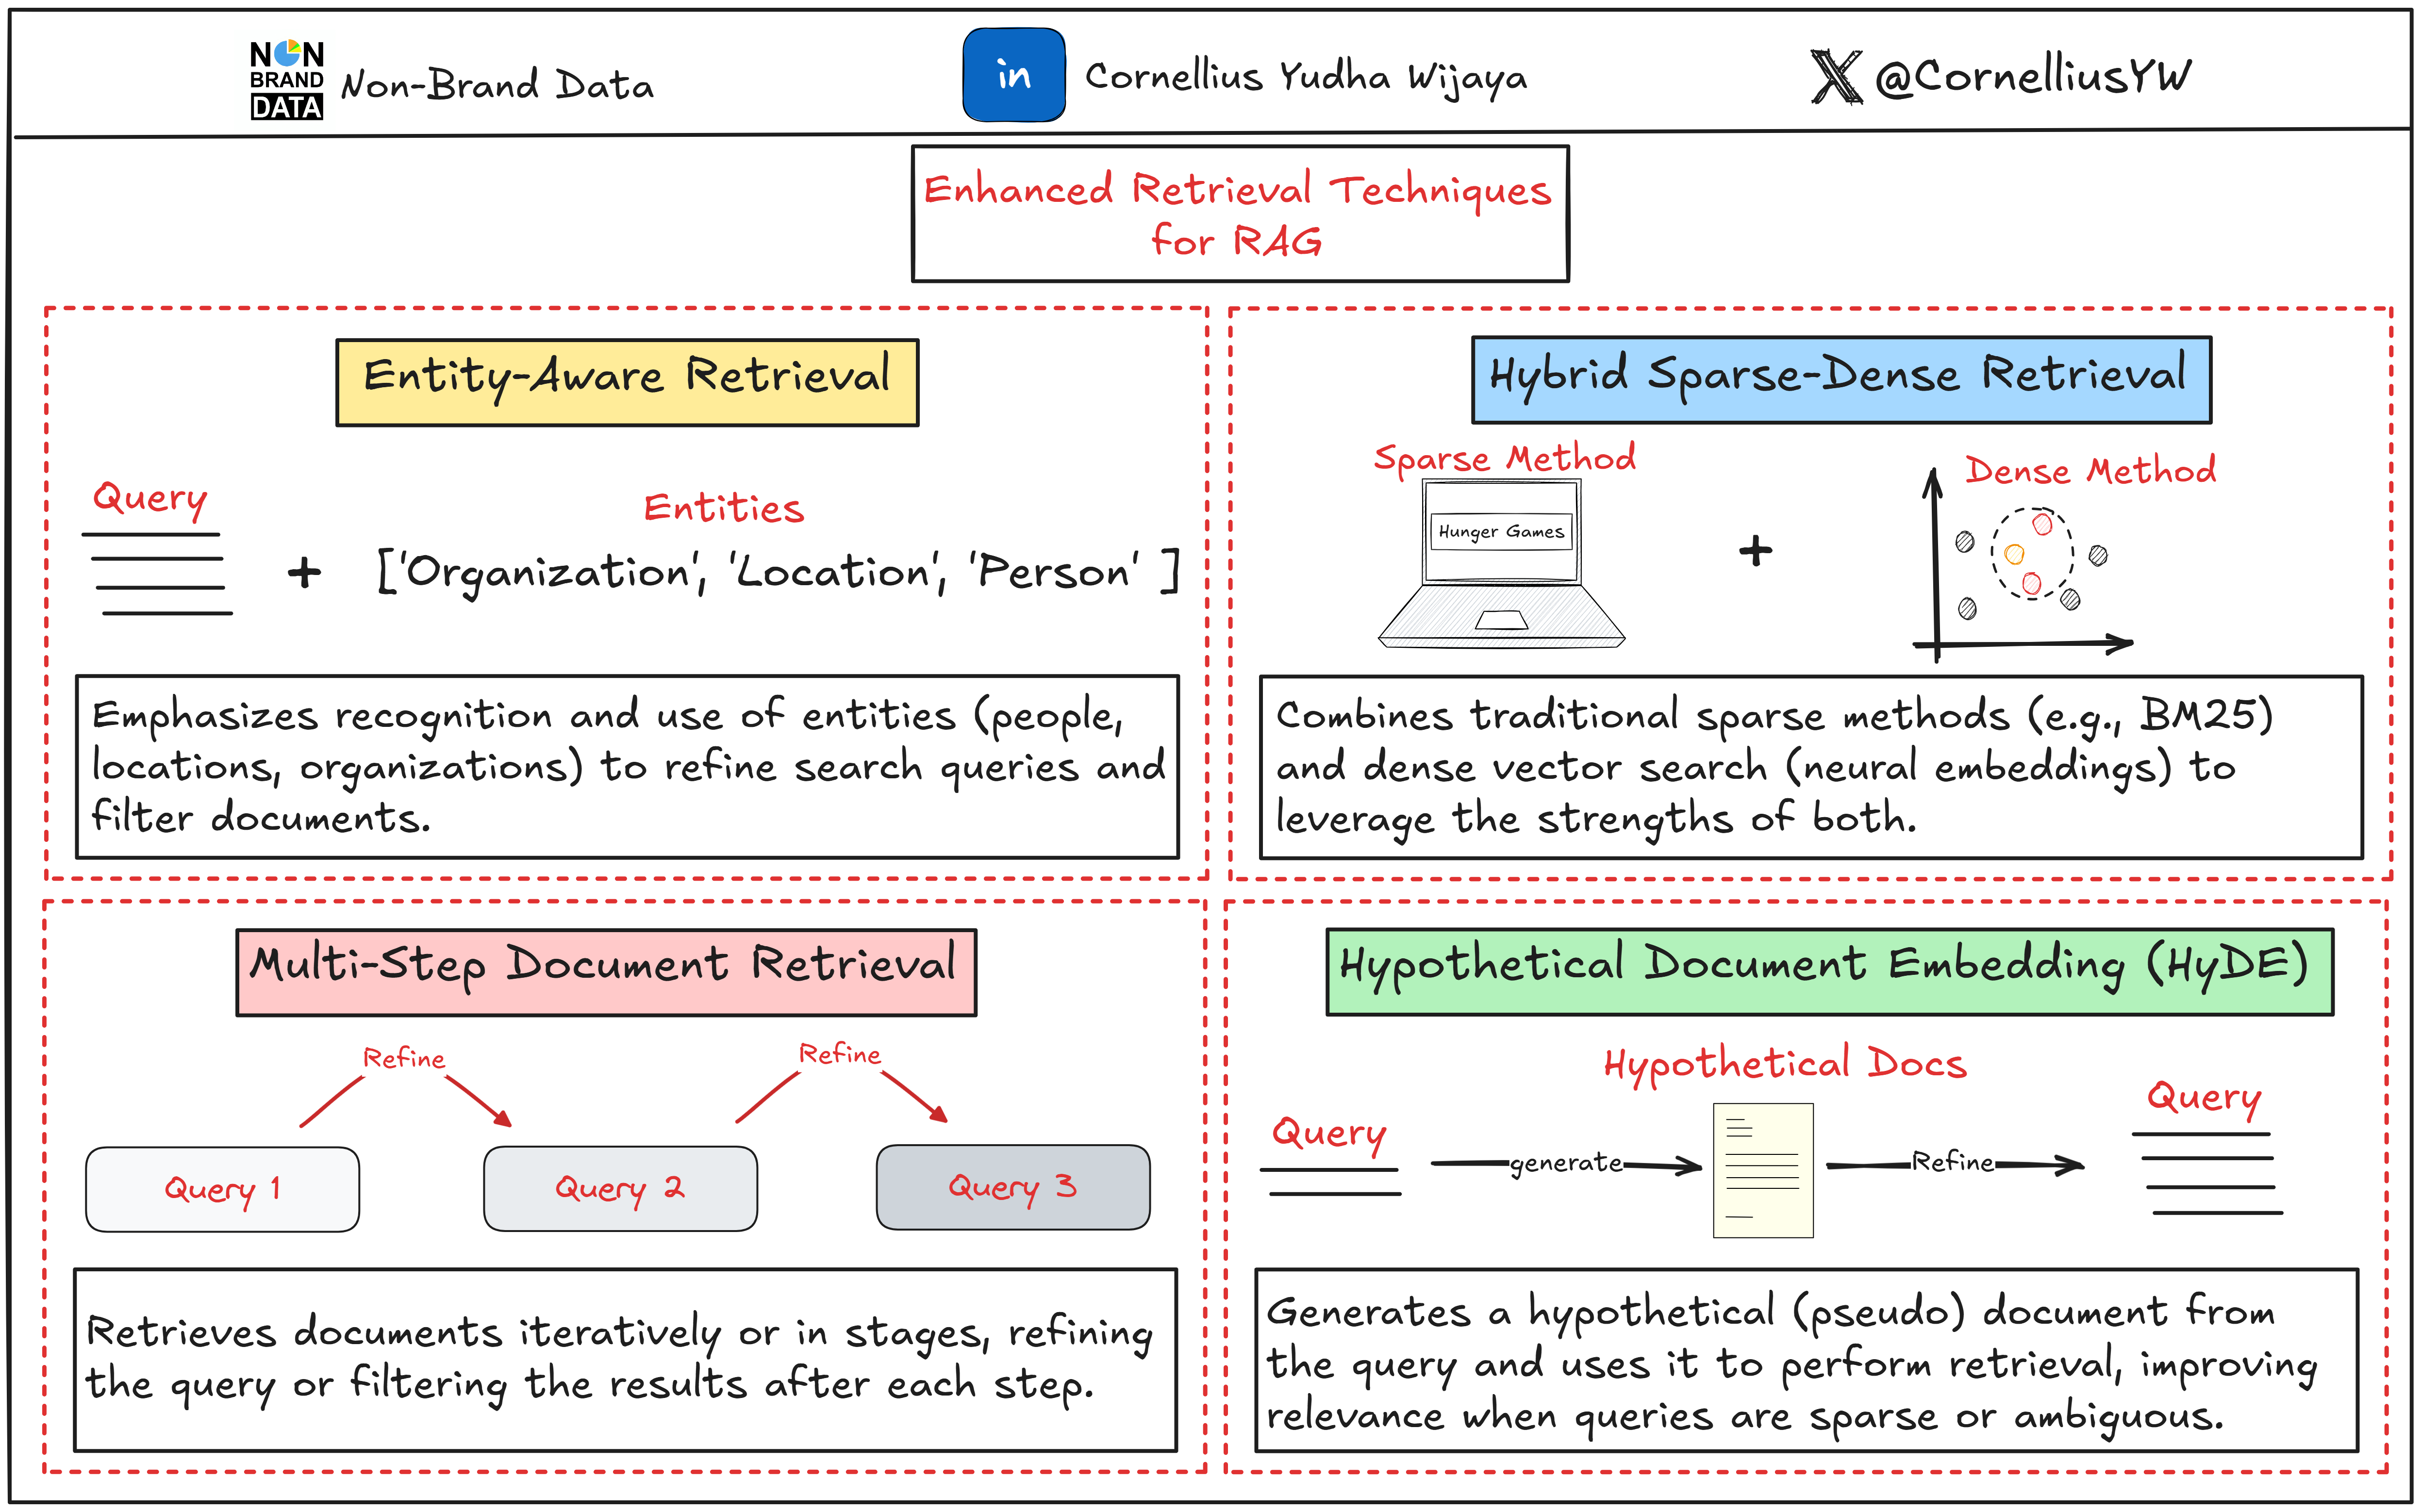

## Library Installation

Start by installing the library used in this Notebook

In [8]:
!pip install -q chromadb pypdf2 sentence-transformers litellm langchain rank_bm25

## Import the Libraries and set the environment variables

In [2]:
import os
import PyPDF2
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import litellm
from litellm import completion
from langchain.text_splitter import RecursiveCharacterTextSplitter
from rank_bm25 import BM25Okapi
import numpy as np

# Set environment variables (uncomment if needed)
# os.environ["HUGGINGFACE_TOKEN"] = "your_huggingface_token_here"
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key_here"
os.environ['LITELLM_LOG'] = 'DEBUG'

# Retrieve environment variables
# HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'fields' has been removed
  warnings.warn(message, UserWarning)


## Extract Text from folder containing PDF files

In [3]:
def extract_text_from_pdfs(folder_path):
    all_text = ""
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    all_text += page.extract_text()
    return all_text

pdf_folder = "dataset"
all_text = extract_text_from_pdfs(pdf_folder)

## Text Splitter

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Size of each chunk
    chunk_overlap=50,  # Overlap between chunks to maintain context
    separators=["\n\n", "\n", " ", ""]  # Splitting hierarchy
)

chunks = text_splitter.split_text(all_text)

## Initialize ChromaDB and Embedding Model

In [5]:
# Initialize a persistent ChromaDB client
client = chromadb.PersistentClient(path="chroma_db")

# Load the SentenceTransformer model for text embeddings
text_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Delete existing collection (if needed)
try:
    client.delete_collection(name="knowledge_base")
    print("Deleted existing collection: knowledge_base")
except Exception as e:
    print(f"Collection does not exist or could not be deleted: {e}")

# Create a new collection for text embeddings
collection = client.create_collection(name="knowledge_base")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Collection does not exist or could not be deleted: Collection knowledge_base does not exist.


## Add Text Chunks to ChromaDB

In [17]:
for i, chunk in enumerate(chunks):
    # Generate embeddings for the chunk
    embedding = text_embedding_model.encode(chunk)

    # Add to the collection with metadata
    collection.add(
        ids=[f"chunk_{i}"],  # Unique ID for each chunk
        embeddings=[embedding.tolist()],  # Embedding vector
        metadatas=[{"source": "pdf", "chunk_id": i}],  # Metadata
        documents=[chunk]  # Original text
    )

## Semantic Search Function

In [18]:
def semantic_search(query, top_k=2):
    # Generate embedding for the query
    query_embedding = text_embedding_model.encode(query)

    # Query the collection
    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=top_k
    )
    return results

## Hybrid Sparse-Dense Retrieval

Hybrid Sparse-Dense Retrieval combines both sparse (e.g., BM25) and dense (e.g., neural embeddings) retrieval methods. Sparse retrieval is good at keyword matching, while dense retrieval captures semantic meaning. By combining both, the retrieval system can leverage the strengths of each method to improve overall performance.

In [19]:
def hybrid_retrieval(query, top_k=2):
    # Dense retrieval using embeddings
    dense_results = semantic_search(query, top_k)

    # Sparse retrieval using BM25
    # Tokenize the chunks (split into words)
    tokenized_chunks = [chunk.split() for chunk in chunks]

    # Initialize BM25
    bm25 = BM25Okapi(tokenized_chunks)

    # Tokenize the query
    tokenized_query = query.split()

    # Get BM25 scores for the query
    bm25_scores = bm25.get_scores(tokenized_query)

    # Get the top_k indices based on BM25 scores
    sparse_indices = np.argsort(bm25_scores)[-top_k:][::-1]

    # Combine results
    combined_results = {
        "documents": dense_results['documents'][0] + [chunks[i] for i in sparse_indices],
        "metadatas": dense_results['metadatas'][0] + [{"source": "pdf", "chunk_id": i} for i in sparse_indices]
    }
    return combined_results

## Entity-Aware Retrieval

Entity-Aware Retrieval involves enhancing the retrieval process by focusing on specific entities mentioned in the query. This means that the retrieval system is designed to prioritize documents or passages that contain the entities mentioned in the query, thereby improving the relevance of the retrieved documents.

In [20]:
def entity_aware_retrieval(query, entities, top_k=2):
    # Add entity information to the query
    enriched_query = f"{query} Entities: {', '.join(entities)}"

    # Perform semantic search with the enriched query
    results = semantic_search(enriched_query, top_k)
    return results

## Hypothetical Document Embedding (HyDE)

Generate a hypothetical document that answers the query and use its embedding for retrieval.

In [21]:
def hyde_retrieval(query, top_k=2):
    # Generate a hypothetical document using a language model
    prompt = f"Generate a hypothetical document that answers the query: {query}"
    hypothetical_doc = completion(
        model="gemini/gemini-1.5-flash",
        messages=[{"content": prompt, "role": "user"}],
        api_key=GEMINI_API_KEY
    )['choices'][0]['message']['content']

    # Generate embedding for the hypothetical document
    hypothetical_embedding = text_embedding_model.encode(hypothetical_doc)

    # Query the collection using the hypothetical embedding
    results = collection.query(
        query_embeddings=[hypothetical_embedding.tolist()],
        n_results=top_k
    )
    return results

## Multi-Step Document Retrieval

Multi-Step Document Retrieval involves retrieving documents in multiple steps, where each step refines the search based on the results of the previous step. This approach allows for a more comprehensive and accurate retrieval process, especially when dealing with complex queries.

In [22]:
def multi_step_retrieval(query, steps=2):
    context = ""
    for step in range(steps):
        # Perform retrieval with the current query
        results = semantic_search(query)
        context += "\n".join(results['documents'][0]) + "\n"

        # Refine the query for the next step
        refined_query = f"{query} Specifically, {context}"
        query = refined_query

    return context

## Generate Response Using LiteLLM and Gemini

In [23]:
def generate_response(query, context):
    # Combine the query and context for the prompt
    prompt = f"Query: {query}\nContext: {context}\nAnswer:"

    # Call the Gemini model via LiteLLM
    response = completion(
        model="gemini/gemini-1.5-flash",  # Use the Gemini model
        messages=[{"content": prompt, "role": "user"}],
        api_key=GEMINI_API_KEY
    )

    # Extract and return the generated text
    return response['choices'][0]['message']['content']

In [24]:
query = "What is the insurance for car?"
entities = ["car", "insurance"]

# Entity-aware retrieval
entity_results = entity_aware_retrieval(query, entities)
print("Entity-Aware Retrieval Results:")
for i, result in enumerate(entity_results['documents'][0]):
    print(f"Result {i+1}: {result}\n")

# Hypothetical Document Embedding (HyDE)
hyde_results = hyde_retrieval(query)
print("HyDE Retrieval Results:")
for i, result in enumerate(hyde_results['documents'][0]):
    print(f"Result {i+1}: {result}\n")

# Multi-step document retrieval
context_multi_step = multi_step_retrieval(query)
response_multi_step = generate_response(query, context_multi_step)
print("Multi-Step Retrieval Response:\n", response_multi_step)

# Hybrid sparse-dense retrieval
hybrid_results = hybrid_retrieval(query)
print("Hybrid Retrieval Results:")
for i, result in enumerate(hybrid_results['documents']):
    print(f"Result {i+1}: {result}\n")

Entity-Aware Retrieval Results:
Result 1: policyholder’s car from a collision. 
5. Comprehensive, for damage to the poli-
cyholder’s car not involving a collision 
with another car (including damage 
from fire, explosions, earthquakes, floods, and riots), and theft. 6. Uninsured motorists coverage, for costs 
resulting from an accident involving a hit-and-run driver or a driver who does not have insurance. 
AUTO INSURANCE PREMIUM
The price an insurance company charges 
for coverage, based on the frequency and

Result 2: Overview	 I.I.I.	Insurance	Handbook			www.iii.org/insurancehandbook	 	3Auto Insurance Basics
Auto insurance protects against financial loss in the event of an accident. It is a 
contract between the policyholder and the insurance company. The policyhold-er agrees to pay the premium and the insurance company agrees to pay losses as defined in the policy.
Auto insurance provides property, liability and medical coverage:
	Property coverage pays for damage to, or theft of,